## Application of NMRQNet on plasma samples collected with other anticoagulants


### Loading packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
import multiprocessing as mp

import os
import sys
import random
import numpy as np
from numpy import array
import time
from functools import partial
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure,axvline
import pandas as pd
from copy import deepcopy
import tqdm


If using Google Colab, connect to the google drive to load the data and save the results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p drive
os.chdir('drive/MyDrive/')  

Mounted at /content/drive


### Load plasma samples and reference library

In [ ]:
#plasma samples
hp_data=pd.read_csv('./tutorial_data/example_heparin_hp.csv')
test_data=np.array(hp_data)[:,2:].T
test_data=test_data.reshape((test_data.shape[0],test_data.shape[1],1))
ppm=hp_data['ppm']

In [ ]:
#reference library
total_lib=pd.read_csv('./tutorial_data/library_for_other_plasma.csv')
total_lib.index=total_lib['Unnamed: 0']
del total_lib['Unnamed: 0']
print(total_lib.shape)

(65, 12000)


Visualization of the raw NMR spectrum

Text(0, 0.5, 'Intensity (a.u.)')

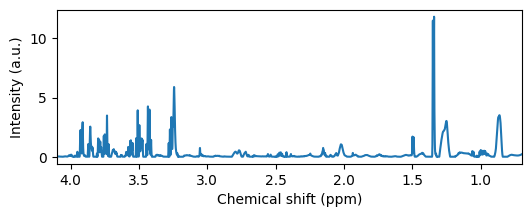

In [ ]:
n=0 #spectrum index
plt.figure(figsize=[6,2])
plt.plot(ppm,test_data[n,:,0])
plt.xlim(4.1,0.7)
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")

## Initialize the quantifications with CRNN predictions
We load weights from the pre-trained CRNN model and make the initial predictions for components within each plasma spectrum.

In [ ]:
from prediction_dp import Test_data
pred_test_data=Test_data(test_data = test_data)
predict_test_hp=pred_test_data.pred_with_deep_learning(weight='./model_plasma_quant/model_plasma_quant')
predict_test_hp.shape #number of samples, number of components in the reference library


Instructions for updating:
Colocations handled automatically by placer.
/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(1, 65)

Visualize the initial prediction results

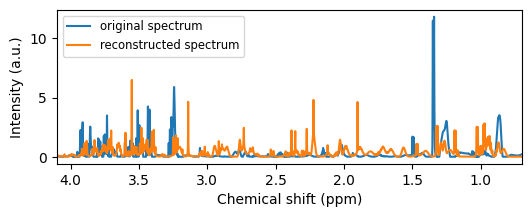

In [ ]:
n=0 #spectrum index
reconstr=np.matmul(predict_test_hp[n,:], total_lib) #reconstruct the whole spectrum from predicted results and the reference library
plt.figure(figsize=[6,2])
plt.plot(ppm,test_data[n,:,0],label="original spectrum")
plt.plot(ppm,np.array(reconstr),label="reconstructed spectrum")
plt.xlim(4.1,0.7)
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")
plt.legend(loc="best",fontsize="small")

### Global positional correction to better align the results

In [ ]:
from global_correction import pair_original_reconstr
pair_class = pair_original_reconstr(predict_test_hp = predict_test_hp, 
                                    original_hp = test_data)

In [ ]:
#range(0,1) specifies the sample range you would like to process when you have multiple samples
#total specifies the number of samples to process

#region*region_step = 12000, the input shape
#region_step could be further minimized with the increase of region to optimize the results

pool = mp.Pool(4)
global_correct_spectra=list(tqdm.tqdm(pool.imap(partial(pair_class.global_correct, 
                                                        total_lib=np.array(total_lib),region=30, region_step=400),range(0,1)),
                                      total = 1, position = 0))


100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


In [ ]:
best_step = []
for i in range(0,len(global_correct_spectra)):
  best_step.append(global_correct_spectra[i][1]) 

best_step #estimated global correction step for each sample

[103]

Visualize the global postional corrected spectra

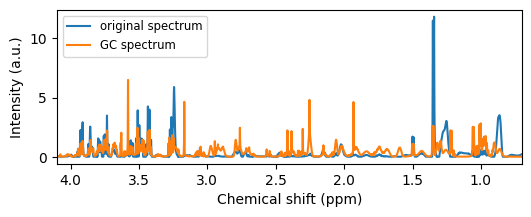

In [ ]:
a=0 #a,b are tuned to check regional alignment
b=12000
n=0 #spectrum index
plt.figure(figsize=[6,2])
plt.plot(ppm[a:b],test_data[n,:,0][a:b],label="original spectrum") 
plt.plot(ppm[a:b],np.array(global_correct_spectra[n][0])[a:b],label="GC spectrum") #global corrected spectrum
plt.xlim(np.max(ppm[a:b]),np.min(ppm[a:b]))
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")
plt.legend(loc="best",fontsize="small")
plt.show()

### Optimize on positions and concentrations with stochastic hill climbing

In [ ]:
from optimize_stochastic_hillclimbing import optimize_pos_concen
opt_pos_concen_class = optimize_pos_concen(predict_test_hp= predict_test_hp, ori_data = test_data)


*   Note that to further optimize the performance on your data, you may need to increase n_iter=500, step_range=50, max_concen=10, and decrease min_concen=0.2
*   Default parameters are able to deal with most cases

In [ ]:
pool = mp.Pool(4)
opt_pos_concen_results = list(tqdm.tqdm(pool.imap(partial(opt_pos_concen_class.optimize_pos_concen, n_iter= 500, 
                                                          total_lib=total_lib, best_step=best_step,step_range = 50, 
                                                          min_concen = 0.2,max_concen = 10),range(0,1)),
                                        total = 1,position =0))


100%|██████████| 1/1 [01:32<00:00, 92.71s/it]


Visualize the reconstructed spectrum after the optimization step

Mean squared error between the original and reconstructed spectra: 0.07077055229699894


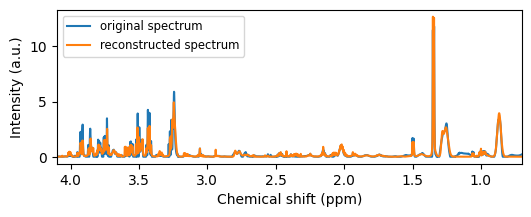

In [ ]:
n=0 #spectrum index
print('Mean squared error between the original and reconstructed spectra:',opt_pos_concen_results[n][1])
a=0
b=12000
plt.figure(figsize=[6,2])
plt.plot(ppm[a:b],test_data[n,:,0][a:b],label="original spectrum")
plt.plot(ppm[a:b],(np.matmul(opt_pos_concen_results[n][0],opt_pos_concen_results[n][2])/np.sum(opt_pos_concen_results[n][0]))[a:b],
         label="reconstructed spectrum")
plt.xlim(np.max(ppm[a:b]),np.min(ppm[a:b]))
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")
plt.legend(loc="best",fontsize="small")
plt.show()


### Further optimize the performence on concentrations with stochastic hill climbing

This step provides the option for user to further boost the performance by optimizing only on concentration

In [ ]:
from optimize_concen import optimize_concen
opt_concen_class= optimize_concen(opt_pos_concen_results, ori_data = test_data)

In [ ]:
pool = mp.Pool(4)
opt_concen_results = list(tqdm.tqdm(pool.imap(partial(opt_concen_class.optimize_concen, n_iter= 1000, 
                                                      min_concen = 0.2,max_concen = 10),
                                              range(0,1)),total = 1, position =0))


100%|██████████| 1/1 [00:31<00:00, 31.36s/it]


Visualize the reconstructed spectrum after all the optimization steps

Mean squared error between the original and reconstructed spectra: 0.06804769786783198


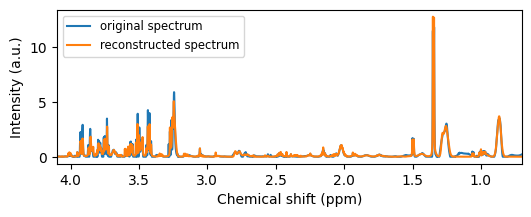

In [ ]:
n=0 #spectrum index
print('Mean squared error between the original and reconstructed spectra:',opt_concen_results[n][1])
plt.figure(figsize=[6,2])
plt.plot(ppm,test_data[n,:,0],label="original spectrum") 
plt.plot(ppm,(np.matmul(opt_concen_results[n][0],
                             opt_pos_concen_results[n][2])/np.sum(opt_concen_results[n][0])),label="reconstructed spectrum")
plt.xlim(np.max(ppm),np.min(ppm))
plt.legend(loc="best",fontsize="small")
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")
plt.show()

### Final visualization check

Regional check between the original spectrum and the final reconstructed spectrum

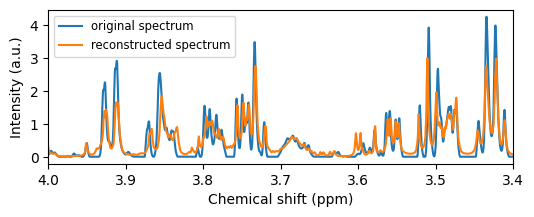

In [ ]:
n=0 #spectrum index
a=3.4 #a,b are tuned to specify the chemical shift region
b=4
plt.figure(figsize=[6,2])
plt.plot(ppm[(ppm>a) & (ppm<b)],test_data[n,:,0][(ppm>a) & (ppm<b)],label="original spectrum")
plt.plot(ppm[(ppm>a) & (ppm<b)],(np.matmul(opt_concen_results[n][0],
                             opt_pos_concen_results[n][2])/np.sum(opt_concen_results[n][0]))[(ppm>a) & (ppm<b)],
         label = "reconstructed spectrum")
plt.legend(loc="best",fontsize="small")
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")
plt.xlim(b,a)
plt.show()

Visualize the mapping performance for individual metabolite

Alanine


(4.1, 0.7)

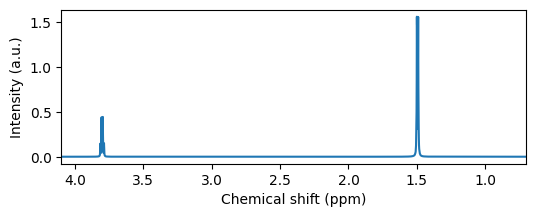

In [ ]:
n=0 #spectrum index
meta_name=np.array(total_lib.index) #extract metabolite list
meta_index=np.where(meta_name=="Alanine")[0][0] #change metabolite name here or specify the index in the next line
#meta_index = 0
print(meta_name[meta_index])

#reconstruct the metabolite-specific spectrum based on the estimated concentrations and the library
quant_meta=(opt_concen_results[n][0][meta_index]/np.sum(opt_concen_results[n][0]))*opt_pos_concen_results[n][2][meta_index,:]
plt.figure(figsize=(6,2))
plt.plot(ppm,quant_meta)
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")
plt.xlim(4.1,0.7)

Text(0, 0.5, 'Intensity (a.u.)')

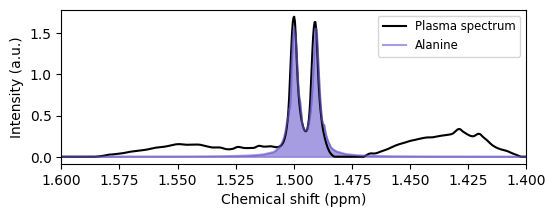

In [ ]:
#Align the reconstructed metabolite-specific spectrum to the original plasma spectrum
a=1.4
b=1.6

fig, ax = plt.subplots(figsize=(6,2))
ax.plot(ppm[(ppm>a) & (ppm<b)],test_data[n,:,0][(ppm>a) & (ppm<b)],color="black",label="Plasma spectrum")
ax.plot(ppm[(ppm>a) & (ppm<b)],quant_meta[(ppm>a) & (ppm<b)],color="slateblue",alpha=0.6,label=meta_name[meta_index])
ax.set_xlim(b,a)
ax.fill_between(ppm[(ppm>a) & (ppm<b)], 0, quant_meta[(ppm>a) & (ppm<b)], color="slateblue",alpha=0.6)
ax.legend(loc="best",fontsize="small")
ax.set_xlabel("Chemical shift (ppm)")
ax.set_ylabel("Intensity (a.u.)")


### Save the results

In [ ]:
output_path = './results/'

for n in range(0,1):
  coef_file = output_path+str('coef_'+str(n+1)+'.txt') #estimated concentrations
  lib_file = output_path +str('lib_'+str(n+1)+'.txt') #positional corrected library
  
  np.savetxt(coef_file,opt_concen_results[n][0])
  np.savetxt(lib_file,opt_pos_concen_results[n][2])